# **Final Project - Prediction of Rating Based on TripAdvisor Reviews**
Daria Butyrskaya, Ashish Dahal

**Note: 4 models have been used in the project. However BERT, LSTM and CNN take long time to train. Especially because 5 fold cross validation has been used for LSTM and CNN. Additionally, because of resource limitations, more training with various preprocessing steps and hyperparameters could not be carried out extensively. It takes approx. 1.5 hours to run the notebook.**

# **1. Import Libraries**

In [1]:
# Measure time of execution for the notebook
from time import time
start = time()

In [2]:
# download necessary packages
!pip3 install ktrain
!pip install wget
import wget
wget.download("http://nlp.stanford.edu/data/glove.6B.zip")
!unzip "glove.6B.zip"

In [3]:
import gc

import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
from wordcloud import WordCloud

import ktrain
from ktrain import text

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, Dropout, Flatten, MaxPooling1D
from keras import regularizers
from keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **2. Import Dataset**

In [4]:
# dataset https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews 
 
# import dataset stored in drive
url = "https://drive.google.com/file/d/1pkGZOReV1VFG-xpO8t_u6RkHNg3QEBAL/view?usp=sharing"
id = url.split('/')[-2]
url1='https://drive.google.com/uc?id=' + id
dataset = pd.read_csv(url1)
print("dataset.columns: ", dataset.columns)

dataset.columns:  Index(['Review', 'Rating'], dtype='object')


# **3. Utility Functions and Parameters**

In [5]:
# Parameters

RANDOM_SEED = 67
K_BEST_FEATURES = 4000

In [6]:
# function to remove punctuation
def remove_punctuation(col):
  return col.str.replace(r'[^\w\s]+', '')

In [7]:
# function to remove stopwords
def remove_stopwords(col):
  stop_words = stopwords.words('english')
  return col.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [8]:
# function to lowercase text
def lowercase(col):
  return col.str.lower()

In [9]:
# function to lemmatize words
def lemmatize_words(text):
  lemmatizer = WordNetLemmatizer()
  words = text.split()
  words = [lemmatizer.lemmatize(word,pos='v') for word in words]
  return ' '.join(words)

In [10]:
# function to show word cloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=RANDOM_SEED).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [11]:
# function to visualize the ratings distribution
def show_ratings_distribution(dataset):
  fig = px.histogram(dataset['Rating'],
                   labels={'value': 'Rating',
                           'count': 'Frequency',
                           'color': 'Rating'}, color=dataset['Rating'])
  fig.update_layout(bargap=0.2)
  fig.update_traces(marker=dict(line=dict(color='#000000', width=2)))
  fig.update_layout(title_text='Distribution of the Ratings',
                    title_x=0.5, title_font=dict(size=20))
  fig.show()

In [12]:
# function to show frequent words
def show_frequent_words(dataset):
  mostUsedWords = dataset['Review'].str.split(expand=True).stack().value_counts()
  mostUsedWords_top200 = mostUsedWords[:200]

  fig = px.treemap(mostUsedWords_top200, path=[mostUsedWords_top200.index], values=0)
  fig.update_layout(title_text='The 200 Most Frequest Words',
                    title_x=0.5, title_font=dict(size=20)
                    )
  fig.update_traces(textinfo="label+value")
  fig.show()

In [13]:
# create cnn model
def create_cnn_model():
  # Define the model
  model = Sequential()
  model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length,weights=[embedding_matrix],trainable=False))
  model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [14]:
# create lstm model
def create_lstm_model():
  # Define the model
  model = tf.keras.models.Sequential([tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_length,weights=[embedding_matrix],trainable=False),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(8, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.3),
                                    tf.keras.layers.Dense(num_classes, activation='softmax')])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [15]:
# Train deep learning model with 5 fold cross validation
def kfold_training(model):
  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  # Memory Management
  tf.keras.backend.clear_session()

  # accumulate k fold accuracy scores
  scores = []
  for index, (train_index, val_index) in enumerate(kf.split(X_train_token)):
      X_train, X_val = X_train_token[train_index], X_train_token[val_index]
      
      y_train, y_val = y_train_category[train_index], y_train_category[val_index]
      print(f"Fold {index + 1}:")
      history = model.fit(X_train, y_train, epochs=10, batch_size=250, validation_data=(X_val, y_val), callbacks = EarlyStopping(monitor='val_loss', patience=3))
      print("\n")
      scores.append(history.history['val_accuracy'][-1])

      # Memory Management
      tf.keras.backend.clear_session()
      gc.collect()
  print(f"Mean accuracy: {(sum(scores)/len(scores)*100):.2f} %")
  return history

In [16]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  cm = labels = np.asarray(cm).reshape(5,5)
  sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', xticklabels=['1','2','3','4','5'], yticklabels=['1','2','3','4','5']);

# **5. Exploratory Data Analysis**

In [17]:
print("dataset.columns: ", dataset.columns) 

dataset.columns:  Index(['Review', 'Rating'], dtype='object')


In [18]:
dataset.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [20]:
# count of ratings
show_ratings_distribution(dataset)

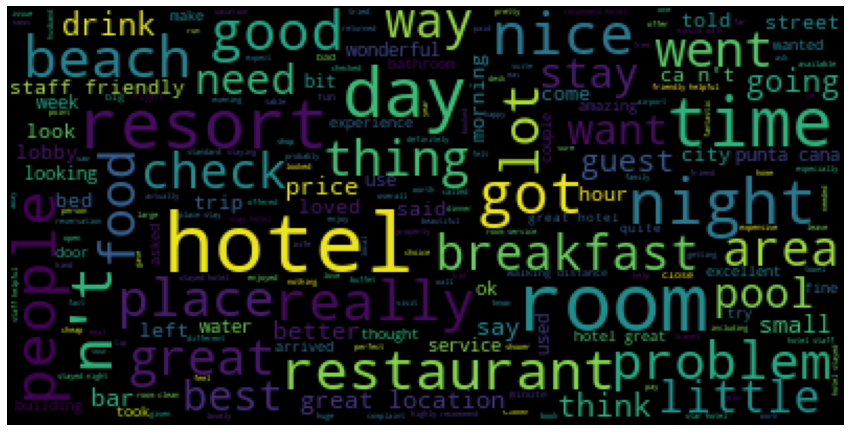

In [21]:
show_wordcloud(dataset["Review"].values)

In [22]:
# see null values
dataset.isnull().sum()

Review    0
Rating    0
dtype: int64

In [23]:
show_frequent_words(dataset)

#**4. Data Pre-processing**

### **4.1.   Delete punctuation**

In [24]:
dataset['Review'] = remove_punctuation(dataset['Review'])

### **4.2. Removing stop words**

In [25]:
dataset['Review'] = remove_stopwords(dataset['Review'])

### **4.3. Lowercase text**

In [26]:
dataset['Review'] = lowercase(dataset['Review'])

### **4.4. Lemmatization**

In [27]:
dataset['Review'] = dataset['Review'].apply(lemmatize_words)

### **4.5. Train/test split**

In [28]:
# split X and y
dataset.Review = dataset.Review.str.replace('\d+', '')
X = dataset['Review'].copy()
y = dataset['Rating'].copy()

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=RANDOM_SEED, stratify=y
)

### **4.6. Tokenizing**



In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X_token = tokenizer.texts_to_sequences(X)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index)+1
exp_sen = 1

print("Vocabulary size: {}".format(vocab_size))
print("max length of sentence: {}".format(max_length))
print("\nResult\n")
print("Original sentence:\n{}".format(X_train[exp_sen])) 
print("\nAfter tokenizing :\n{}".format(X_train_token[exp_sen]))

X_token = pad_sequences(X_token, padding='post', maxlen=max_length)

X_train_token = pad_sequences(X_train_token, padding='post', maxlen=max_length)
print("\nAfter padding :\n{}".format(X_train_token[exp_sen]))

X_test_token = pad_sequences(X_test_token, padding='post', maxlen=max_length)

Vocabulary size: 68989
max length of sentence: 12205

Result

Original sentence:
ok nothing special charge diamond member hilton decide chain shoot th anniversary seattle start book suite pay extra website description suite bedroom bathroom standard hotel room take print reservation desk show say things like tv couch ect desk clerk tell oh mix suit description kimpton website sorry free breakfast get kid embassy suit sit room bathroom bedroom unlike kimpton call suite  day stay offer correct false advertise send kimpton prefer guest website email ask failure provide suite advertise website reservation description furnish hard copy reservation printout website desk manager duty reply solution send email trip guest survey follow email mail guess tell concern guestthe staff range indifferent helpful ask desk good breakfast spot neighborhood hood tell hotels gee best breakfast spot seattle  block away convenient hotel know exist arrive late night  pm inside run bellman busy chat cell phone

### **4.7 Vectorizing**

In [30]:
# Extract text vectors using CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X)
X_vect = vectorizer.transform(X)
X_train_vect = vectorizer.transform(X_train)
X_test_vect = vectorizer.transform(X_test)

### **4.8 Embeddings**

In [31]:
# load pre-trained GloVe embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### **4.9 Encoding**

In [32]:
# Convert the output to categorical
num_classes = 5

# for 
y_category = tf.keras.utils.to_categorical(y-1, num_classes)
# y_train_category = y_train-1
y_train_category = tf.keras.utils.to_categorical(y_train-1, num_classes)
# y_test_category = y_test-1 
y_test_category = tf.keras.utils.to_categorical(y_test-1, num_classes)

# **5. Ratings Prediction**

### **5.1 Naive Bayes**


**Without Feature Selection**

In [33]:
# Train and test naive bayes classifier
NB_clf = MultinomialNB()
NB_clf.fit(X_train_vect, y_train)

# Perform 5-fold cross validation on the classifier
scores = cross_val_score(NB_clf, X_train_vect, y_train, cv=5)

# Print the mean score
print(f"Mean validation accuracy:{scores.mean()*100:.2f} %")

NB_y_pred = NB_clf.predict(X_test_vect)
NB_accuracy = accuracy_score(y_test, NB_y_pred)*100
print(f"Test Accuracy: {NB_accuracy:.2f} %")

print(classification_report(y_test, NB_y_pred));

Mean validation accuracy:53.49 %
Test Accuracy: 54.69 %
              precision    recall  f1-score   support

           1       0.88      0.25      0.39       469
           2       0.37      0.18      0.24       592
           3       0.26      0.01      0.03       721
           4       0.38      0.47      0.42      1993
           5       0.66      0.85      0.74      2988

    accuracy                           0.55      6763
   macro avg       0.51      0.35      0.36      6763
weighted avg       0.52      0.55      0.50      6763



**With Feature Selection**

In [34]:
# Select top k features using chi2
selector = SelectKBest(f_classif, k=500)
X_best = selector.fit_transform(X_vect, y)

# Train and test naive bayes classifier
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y, test_size=0.33, stratify=y, random_state = RANDOM_SEED)
NB_clf = MultinomialNB()
NB_clf.fit(X_train_best, y_train_best)

# Perform 5-fold cross validation on the classifier
scores = cross_val_score(NB_clf, X_train_best, y_train_best, cv=5)

# Print the mean and standard deviation of the scores
print(f"Mean validation accuracy:{scores.mean()*100:.2f} %")

NB_y_pred = NB_clf.predict(X_test_best)
NB_accuracy = accuracy_score(y_test_best, NB_y_pred)*100
print(f"Test Accuracy: {NB_accuracy:.2f} %")

print(classification_report(y_test_best, NB_y_pred));

Mean validation accuracy:59.78 %
Test Accuracy: 59.81 %
              precision    recall  f1-score   support

           1       0.64      0.67      0.66       469
           2       0.40      0.41      0.41       592
           3       0.36      0.32      0.34       721
           4       0.52      0.45      0.48      1993
           5       0.72      0.79      0.75      2988

    accuracy                           0.60      6763
   macro avg       0.53      0.53      0.53      6763
weighted avg       0.59      0.60      0.59      6763



### **5.2. BERT**

In [35]:
# split dataset to train bert model as ktrain accepts target and label dataframe
cutoff = round(len(dataset) * 0.7)
bert_train_dataset = dataset.copy()[:cutoff]
bert_test_dataset = dataset.copy()[cutoff:]

In [36]:
# # prepare target to be compatible with the model
bert_train_dataset.Rating = bert_train_dataset.Rating - 1
bert_test_dataset.Rating = bert_test_dataset.Rating - 1

# split train and validation sets
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(bert_train_dataset, 
                                                                    'Review',
                                                                    label_columns='Rating',
                                                                    preprocess_mode='bert')
# define model
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc)


learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=10)

# train
learner.fit_onecycle(lr=2e-5,
                     epochs=1)

['Rating_0', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4']
       Rating_0  Rating_1  Rating_2  Rating_3  Rating_4
13071       0.0       1.0       0.0       0.0       0.0
10425       0.0       0.0       0.0       1.0       0.0
10826       0.0       0.0       0.0       0.0       1.0
7423        0.0       0.0       0.0       1.0       0.0
7371        0.0       0.0       0.0       1.0       0.0
['Rating_0', 'Rating_1', 'Rating_2', 'Rating_3', 'Rating_4']
       Rating_0  Rating_1  Rating_2  Rating_3  Rating_4
11184       0.0       1.0       0.0       0.0       0.0
3971        1.0       0.0       0.0       0.0       0.0
4364        0.0       1.0       0.0       0.0       0.0
2384        0.0       0.0       1.0       0.0       0.0
2852        0.0       0.0       0.0       0.0       1.0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 400
done.


begin training using onecycle policy with max lr of 2e-05...
1291/1291 [==============================] - 1364s 1s/step - loss: 0.9926 - accuracy: 0.5633 - val_loss: 0.7969 - val_accuracy: 0.6439


In [43]:
# Make predictions
predictor = ktrain.get_predictor(learner.model, preproc)
pred = predictor.predict(bert_test_dataset['Review'].tolist())

193/193 [==============================] - 202s 1s/step


In [44]:
# convert predictions string to rating int
pred = [int(rating[-1]) for rating in pred]
accuracy = accuracy_score (bert_test_dataset['Rating'].values , pred)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.67


**BERT K FOLD CROSS VALIDATION**

The below code is commented for 5 fold cross validation as the there is not enough GPU resources on colab to train it (As seen on the output). However, it works on high GPU machine.

In [58]:
# # prepare target to be compatible with the model
# bert_train_dataset.Rating = bert_train_dataset.Rating - 1
# bert_test_dataset.Rating = bert_test_dataset.Rating - 1


# kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# # accumulate k fold accuracy scores
# val_scores = []
# for index, (train_index, val_index) in enumerate(kf.split(bert_train_dataset)):
#     bert_train_split = bert_train_dataset.iloc[train_index]
    
#     print(f"Fold {index + 1}:")
    
#     (X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(bert_train_split, 
#                                                                       'Review',
#                                                                       label_columns='Rating',
#                                                                       preprocess_mode='bert')

#     model = text.text_classifier(name='bert',
#                               train_data=(X_train, y_train),
#                               preproc=preproc)


#     learner = ktrain.get_learner(model=model,
#                               train_data=(X_train, y_train),
#                               val_data=(X_test, y_test),
#                               batch_size=10)

#     learner.fit_onecycle(lr=2e-5,
#                         epochs=1)
#     val_scores.append(learner.model.history.history['val_accuracy'][0])

In [59]:
# pred = predictor.predict(bert_test_dataset['Review'].tolist())

In [60]:
# # convert predictions string to rating int
# pred = [int(rating[-1]) for rating in pred]
# accuracy = accuracy_score (bert_test_dataset['Rating'].values , pred)
# print(f"Mean validation accuracy: {(sum(val_scores)/len(val_scores)):.2f}")
# print(f'Test accuracy: {accuracy:.2f}')

### **5.3 Long Short-Term Memory**

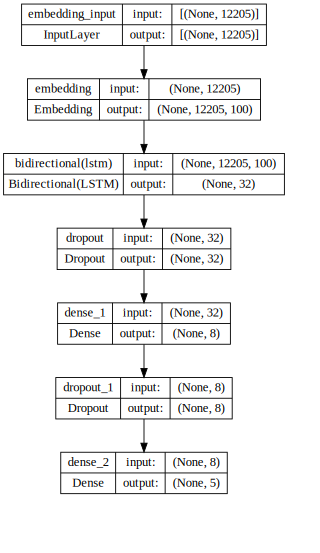

In [45]:
# create lstm
lstm_model = create_lstm_model()

# Visualizing the Neural Network Architecture
SVG(model_to_dot(lstm_model, dpi=80,show_shapes=True).create(prog="dot", format="svg"))

In [46]:
# return last history of kfold
lstm_history = kfold_training(lstm_model)

Fold 1:
Epoch 1/10
44/44 [==============================] - 46s 911ms/step - loss: 1.4726 - accuracy: 0.4264 - val_loss: 1.3779 - val_accuracy: 0.4406
Epoch 2/10
44/44 [==============================] - 39s 888ms/step - loss: 1.3769 - accuracy: 0.4374 - val_loss: 1.2912 - val_accuracy: 0.4436
Epoch 3/10
44/44 [==============================] - 39s 885ms/step - loss: 1.3049 - accuracy: 0.4541 - val_loss: 1.2293 - val_accuracy: 0.4883
Epoch 4/10
44/44 [==============================] - 40s 909ms/step - loss: 1.2507 - accuracy: 0.4773 - val_loss: 1.1644 - val_accuracy: 0.5004
Epoch 5/10
44/44 [==============================] - 39s 885ms/step - loss: 1.1944 - accuracy: 0.4945 - val_loss: 1.1276 - val_accuracy: 0.5259
Epoch 6/10
44/44 [==============================] - 39s 882ms/step - loss: 1.1627 - accuracy: 0.4987 - val_loss: 1.0976 - val_accuracy: 0.5135
Epoch 7/10
44/44 [==============================] - 39s 884ms/step - loss: 1.1334 - accuracy: 0.5065 - val_loss: 1.0840 - val_accuracy

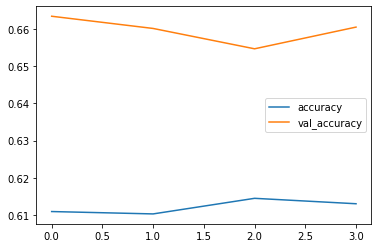

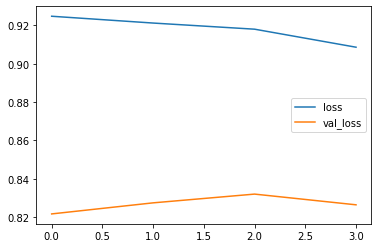

In [47]:
# plot trainning and validation accuracy graph
lstm_metrics = pd.DataFrame(lstm_model.history.history)
lstm_metrics[['accuracy', 'val_accuracy']].plot()
lstm_metrics[['loss', 'val_loss']].plot()

In [48]:
# predict on test data
lstm_y_pred = lstm_model.predict(X_test_token)
lstm_y_pred = np.argmax(lstm_y_pred, axis=1)

212/212 [==============================] - 62s 288ms/step


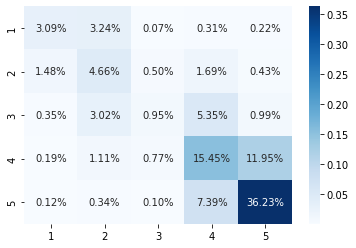

In [49]:
plot_confusion_matrix(np.argmax(y_test_category, axis=1)+1, lstm_y_pred+1)

In [50]:
print(classification_report(np.argmax(y_test_category, axis=1)+1, lstm_y_pred+1));

              precision    recall  f1-score   support

           1       0.59      0.45      0.51       469
           2       0.38      0.53      0.44       592
           3       0.40      0.09      0.14       721
           4       0.51      0.52      0.52      1993
           5       0.73      0.82      0.77      2988

    accuracy                           0.60      6763
   macro avg       0.52      0.48      0.48      6763
weighted avg       0.59      0.60      0.58      6763



### **5.4 Convolutional Neural Network**

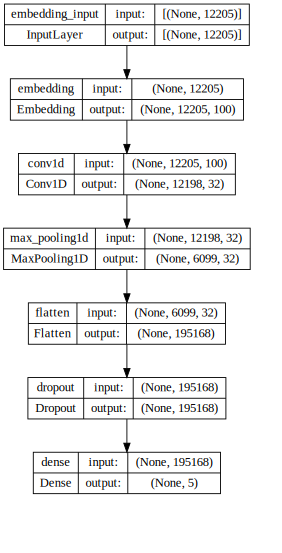

In [51]:
# create cnn
cnn_model = create_cnn_model()
from matplotlib.pyplot import figure

# Visualizing the Neural Network Architecture
SVG(model_to_dot(cnn_model, dpi=80,show_shapes=True).create(prog="dot", format="svg"))

In [52]:
# return last history of kfold
cnn_history = kfold_training(cnn_model)

Fold 1:
Epoch 1/10
44/44 [==============================] - 21s 354ms/step - loss: 1.3522 - accuracy: 0.4303 - val_loss: 1.2655 - val_accuracy: 0.4388
Epoch 2/10
44/44 [==============================] - 13s 300ms/step - loss: 1.2015 - accuracy: 0.4726 - val_loss: 1.1806 - val_accuracy: 0.4967
Epoch 3/10
44/44 [==============================] - 13s 299ms/step - loss: 1.0815 - accuracy: 0.5545 - val_loss: 1.1203 - val_accuracy: 0.5459
Epoch 4/10
44/44 [==============================] - 13s 298ms/step - loss: 0.9920 - accuracy: 0.6008 - val_loss: 1.0984 - val_accuracy: 0.5317
Epoch 5/10
44/44 [==============================] - 13s 298ms/step - loss: 0.9361 - accuracy: 0.6336 - val_loss: 1.1002 - val_accuracy: 0.5393
Epoch 6/10
44/44 [==============================] - 13s 299ms/step - loss: 0.8883 - accuracy: 0.6655 - val_loss: 1.0813 - val_accuracy: 0.5590
Epoch 7/10
44/44 [==============================] - 13s 299ms/step - loss: 0.8537 - accuracy: 0.6803 - val_loss: 1.0913 - val_accuracy

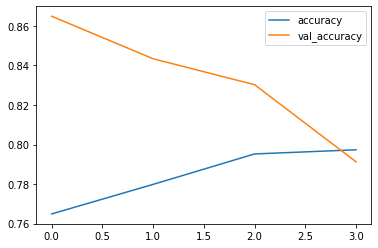

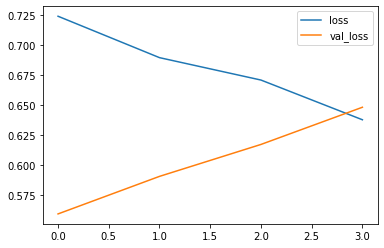

In [53]:
# plot trainning and validation accuracy graph
cnn_metrics = pd.DataFrame(cnn_model.history.history)
cnn_metrics[['accuracy', 'val_accuracy']].plot()
cnn_metrics[['loss', 'val_loss']].plot()

In [54]:
# predict on test data
cnn_y_pred = cnn_model.predict(X_test_token)
cnn_y_pred = np.argmax(cnn_y_pred, axis=1)

212/212 [==============================] - 3s 11ms/step


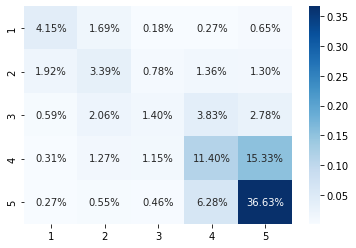

In [55]:
plot_confusion_matrix(np.argmax(y_test_category, axis=1), cnn_y_pred)

In [56]:
print(classification_report(np.argmax(y_test_category, axis=1), cnn_y_pred))

              precision    recall  f1-score   support

           0       0.57      0.60      0.59       469
           1       0.38      0.39      0.38       592
           2       0.35      0.13      0.19       721
           3       0.49      0.39      0.43      1993
           4       0.65      0.83      0.73      2988

    accuracy                           0.57      6763
   macro avg       0.49      0.47      0.46      6763
weighted avg       0.54      0.57      0.54      6763



In [57]:
# time taken for execution
end = time()
time_taken = end - start
print(f"Execution time for notebook: {time_taken:.2f} seconds")

Execution time for notebook: 4913.99 seconds
